# Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
# Keras and Tensorflow

# Step By Step Process
- We will collect he stock data -Apple
- pre process the data- Train and test
- Create a Stacked LSTM Model
- Predict the test data and plot the output
- Predict the future 30 days and plot the output

In [2]:
# Data Collection
import pandas_datareader
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
from datetime import datetime
yf.pdr_override()

In [3]:
df=pdr.get_data_yahoo('AAPL')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600
...,...,...,...,...,...,...
2024-05-13,185.440002,187.100006,184.619995,186.279999,186.279999,72044800
2024-05-14,187.509995,188.300003,186.289993,187.429993,187.429993,52393600
2024-05-15,187.910004,190.649994,187.369995,189.720001,189.720001,70400000


In [4]:
# If we want to convert into csv for offline usage
# df.to_csv('AAPL.csv')

In [5]:
# For the close column , I will do the stock prediction, we can also try with others
df1=df.reset_index()['Close']

In [6]:
df1.head()

0    0.128348
1    0.121652
2    0.112723
3    0.115513
4    0.118862
Name: Close, dtype: float64

In [7]:
df1.shape

(10949,)

<Axes: >

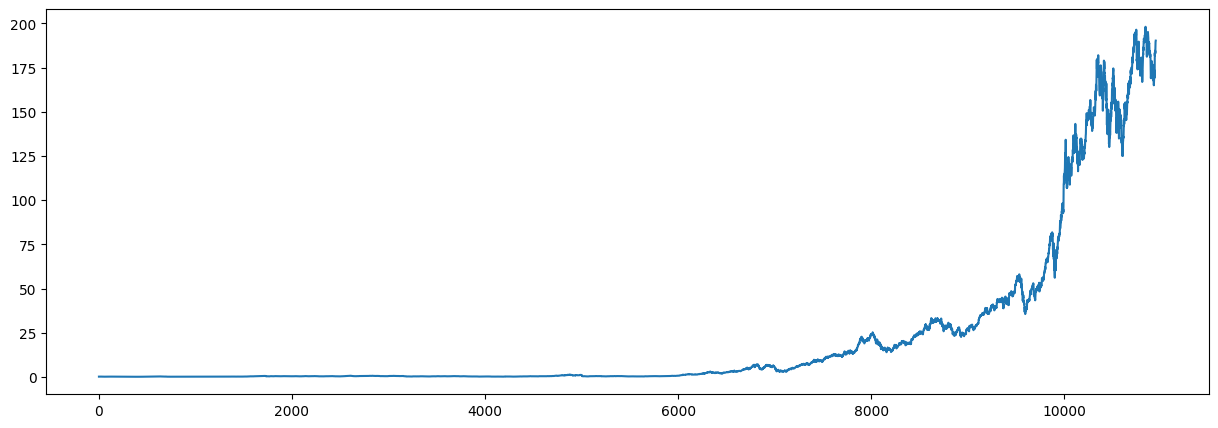

In [8]:
import matplotlib.pyplot as plt
df1.plot(figsize=(15,5))

In [9]:
# LSTM Are very sensitive to the scale of the data, we should transform the valuesin a specif format
# Here we will use min max scaler(Transform values between 0 and1 )
import numpy as np

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1)) # Reshape :- It arranges the data in a new shape of fit_transform

In [11]:
df1

array([[4.00083990e-04],
       [3.66276240e-04],
       [3.21194149e-04],
       ...,
       [9.57639293e-01],
       [9.58245143e-01],
       [9.60416233e-01]])

In [12]:
df1.shape

(10949, 1)

In [13]:
# Pre Process(Train and test split)
# In time series data we will divide the data in a different way
# In time series the values are increasing in a random way
train_size=int(len(df1)*0.65) # train size=65%
test_size=len(df1)-train_size # Test size=35%
train_data,test_data=df1[0:train_size],df1[train_size:]

In [14]:
train_size,test_size

(7116, 3833)

In [15]:
len(train_data),len(test_data)

(7116, 3833)

In [16]:
# Time Steps : Suppose I want to compute next day output,How many previous day we have to consider
# If my time step is 3 , then I will have take previous  3 features
# It will shift one by one(f1,f2,f3 are my previous input and f4 is my output)
# Then for one time stand shift 1 i.e. (f2,f3,f4 are my previous input and f5 is my output)
# this will be present in both train and test data

import numpy
# Convert an array of values into dataset matrix
def create_dataset(dataset,timestep):
    datax,datay=[], []
    for i in range (len(dataset)-timestep-1): # one less because of output
        a=dataset[i:(i+timestep),0]  # In first iteration(0th iteration) , if my time stamp is 100 , then 0-99 will first record and 100 th will be my output
        datax.append(a) # input will be stored here # xtrain
        datay.append(dataset[i+timestep,0]) # Last value i.e. output will be stored # y_train # 0 th index
    return numpy.array(datax),numpy.array(datay)
# better time stand value , better it is

In [17]:
# run it
timestep=100
x_train,y_train= create_dataset(train_data,timestep)
x_test,y_test= create_dataset(test_data,timestep)

In [18]:
x_train.shape,y_train.shape

((7015, 100), (7015,))

In [19]:
x_train.shape,y_train.shape

((7015, 100), (7015,))

In [20]:
# Create a stack Lstm model
# Always Reshape our  x (both train and test) to convert to 3d by adding 1 at last
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) # (7015, 100,1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1) # (3731, 100,1)

In [21]:
x_train.shape,x_train.shape,

((7015, 100, 1), (7015, 100, 1))

In [22]:
### Create  the Stacked LSTM Model(one lstm after that one lstm)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
import tensorflow as tf

In [26]:
# Early stopping ## copy from keras documentation and play with data

import tensorflow as tf
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


In [29]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64,verbose=1)
# try with 100 epoch
# Minimize the loss

Epoch 1/10
110/110 [==============================] - 25s 224ms/step - loss: 5.1871e-07 - accuracy: 1.4255e-04 - val_loss: 0.0057 - val_accuracy: 2.6795e-04
Epoch 2/10
110/110 [==============================] - 23s 213ms/step - loss: 5.8016e-07 - accuracy: 1.4255e-04 - val_loss: 0.0108 - val_accuracy: 2.6795e-04
Epoch 3/10
110/110 [==============================] - 24s 218ms/step - loss: 5.8972e-07 - accuracy: 1.4255e-04 - val_loss: 0.0071 - val_accuracy: 2.6795e-04
Epoch 4/10
110/110 [==============================] - 23s 214ms/step - loss: 4.8483e-07 - accuracy: 1.4255e-04 - val_loss: 0.0064 - val_accuracy: 2.6795e-04
Epoch 5/10
110/110 [==============================] - 25s 225ms/step - loss: 4.7975e-07 - accuracy: 1.4255e-04 - val_loss: 0.0064 - val_accuracy: 2.6795e-04
Epoch 6/10
110/110 [==============================] - 24s 218ms/step - loss: 4.9237e-07 - accuracy: 1.4255e-04 - val_loss: 0.0073 - val_accuracy: 2.6795e-04
Epoch 7/10
110/110 [==============================] - 33s 

In [30]:
# Lets Do the Prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

117/117 [==============================] - 4s 38ms/step


In [32]:
# Transforming to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [38]:
# Calculate the RMSE(Root mean squared error) and Performance Metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_predict,y_train))
# train more

1.4473298221515762

In [36]:
# Test Data RMSE
math.sqrt(mean_squared_error(test_predict,y_test))

68.75452968781106

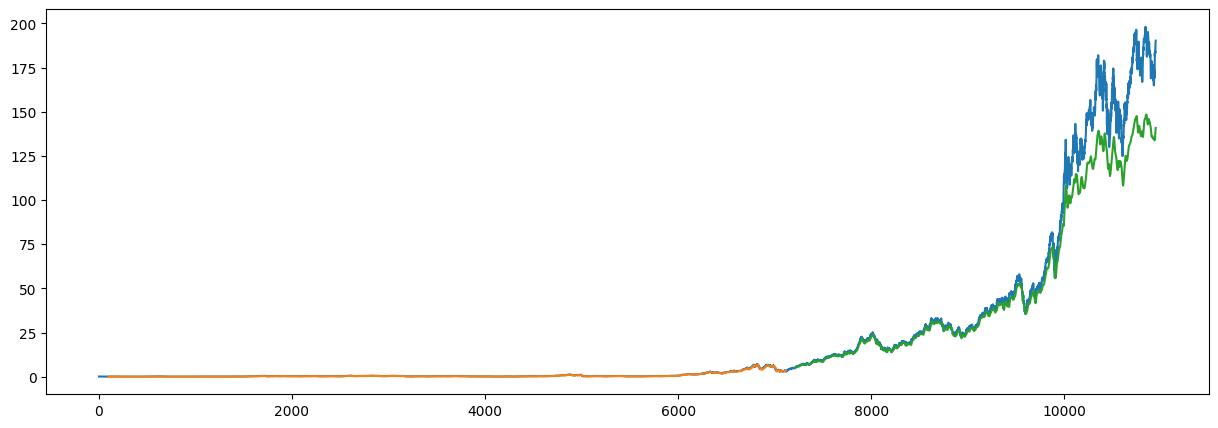

In [52]:
### Ploting

# shift train predictions for plotting
look_back=100
trainPredictPlot=numpy.empty_like(df1)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] =train_predict

# Shift test prediction for plotting

testPredictPlot=numpy.empty_like(df1)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1,:] =test_predict

# Plot baseline and prediction
plt.plot(scaler.inverse_transform(df1)) # Very important
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.rcParams["figure.figsize"]=(15,5)

# Green Color = the predicted data(output for the test data)
# Blue Color = complete data set
# Yellow Color = training data




In [53]:
# Predict For the next 30 days
len(test_data) #I have to take the previous 100 days data to predict

3833

In [54]:
# Takingthe previous 100 days data
x_input=test_data[3733:].reshape(1,-1)
x_input.shape

(1, 100)

In [56]:
# Convert to a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [57]:
temp_input # (previous 100 days data of test data)

[0.9744523137992386,
 0.9749571628025122,
 0.9771282523433722,
 0.9718268370431629,
 0.9370395589285275,
 0.9300215183435717,
 0.9182069885025781,
 0.9145211978701016,
 0.9366356335013699,
 0.9345150827894658,
 0.939816498089675,
 0.9367870959064418,
 0.9384532594031303,
 0.9268911925842225,
 0.9220946262872869,
 0.9521359539748402,
 0.9669293471701113,
 0.9786934152230469,
 0.9852065297638312,
 0.9817732791943381,
 0.9801071156976496,
 0.9712714492109334,
 0.9677876598124845,
 0.949157013579665,
 0.9307788303689312,
 0.9431992868711101,
 0.9380998728049286,
 0.9473393876779046,
 0.9555187427562752,
 0.9560741305885048,
 0.9505707910951655,
 0.9532467296392992,
 0.9446634491337709,
 0.9340101567452943,
 0.9295165922994003,
 0.9280524300367394,
 0.9202265385974684,
 0.9164398243888757,
 0.9202770774264243,
 0.9306273679638593,
 0.9212868524738694,
 0.9144202742939854,
 0.9218422403060988,
 0.9157329741515744,
 0.9123501853701393,
 0.9068468458768001,
 0.8838236358151004,
 0.858679798000

In [67]:
# Demonstrate prediction for next 30 days
from numpy import array

List_output=[]
n_steps=100
i=0
while(i<30): # First it will go in else part

  if(len(temp_input)>100):
    x_input=np.array(temp_input[1:])
    print(" {} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))
    yhat=model.predict(x_input,verbose=0)
    print(" {} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    List_output.extend(yhat.tolist())
    i=i+1

  else:
    x_input=x_input.reshape((1,n_steps,1))  # reshape
    yhat=model.predict(x_input,verbose=0) # Predict
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    List_output.extend(yhat.tolist()) # Adding the y hat value in the final output and also adding it in the previous input(temp input)
    i=i+1

print(List_output) # Adding all the output
# First_output.extend(yhat.tolist()) # Adding the y hat value in the final output and also adding it in the previous input(temp input)
# Now It will have 101 element and so we have to shift from one position and take the remaining data
# then we will move to if
# if temp greater then 100 , then i will shift one position to the right
# then reshape and then predict
# this will go until we do 30 loops

 0 day input [0.91719721 0.92068093 0.92239763 0.93163722 0.92396279 0.94027089
 0.94607715 0.95763929 0.95824514 0.96041623 0.71875846 0.71902382
 0.71472311 0.70619941 0.69434339 0.6801526  0.66451842 0.64814842
 0.63155884 0.61509913 0.5989905  0.58335841 0.56826591 0.553734
 0.53976029 0.52632928 0.51341969 0.5010078  0.48907027 0.47758517
 0.46653137 0.4558897  0.44564214 0.43577161 0.42626163 0.41709685
 0.40826261 0.39974451 0.39152914 0.3836033  0.3759543  0.36857009
 0.36143923 0.35455072 0.34789392 0.34145859 0.33523527 0.32921463
 0.32338783 0.31774682 0.31228316 0.30698961 0.30185863 0.2968834
 0.29205731 0.2873742  0.28282794 0.27841288 0.27412355 0.26995489
 0.26590189 0.26195982 0.25812432 0.25439107 0.25075608 0.24721538
 0.24376537 0.24040256 0.23712361 0.23392525 0.23080453 0.22775857
 0.22478452 0.22187982 0.21904205 0.2162686  0.21355733 0.21090598
 0.20831259 0.2057751  0.20329155 0.20086017 0.19847924 0.1961471
 0.19386217 0.19162287 0.18942773 0.1872755  0.185164

In [68]:
# Plotting
day_new=np.arange(1,101) # 100 index inside this
day_pred=np.arange(101,131) # because we will predict 30 days

In [69]:
len(df1)

10949

In [70]:
df3=df1.tolist()
df3.extend(List_output)

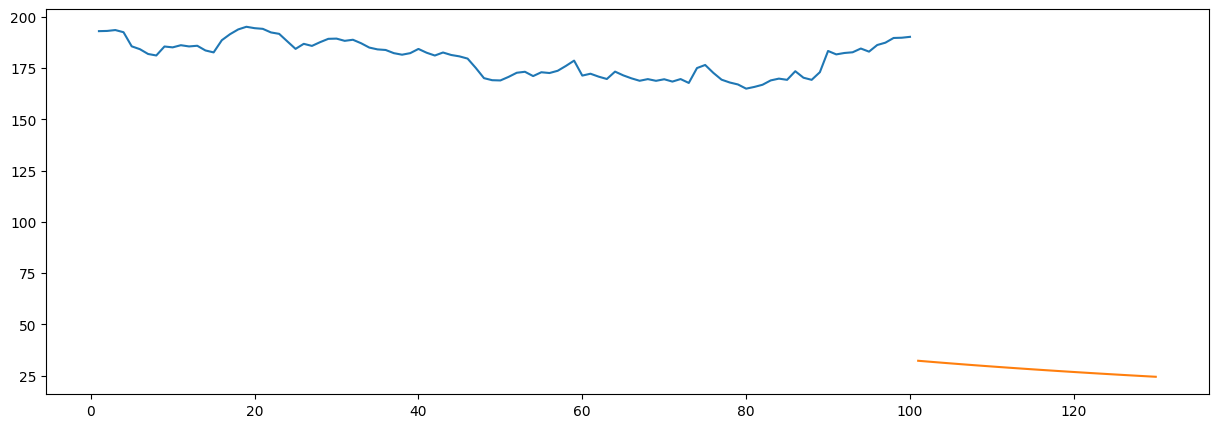

In [72]:
plt.plot(day_new,scaler.inverse_transform(df1[10849:])) # Previous 100 record # real data
plt.plot(day_pred,scaler.inverse_transform(List_output)) # Predicted Data
# Yellow one is the new output ( More training required)

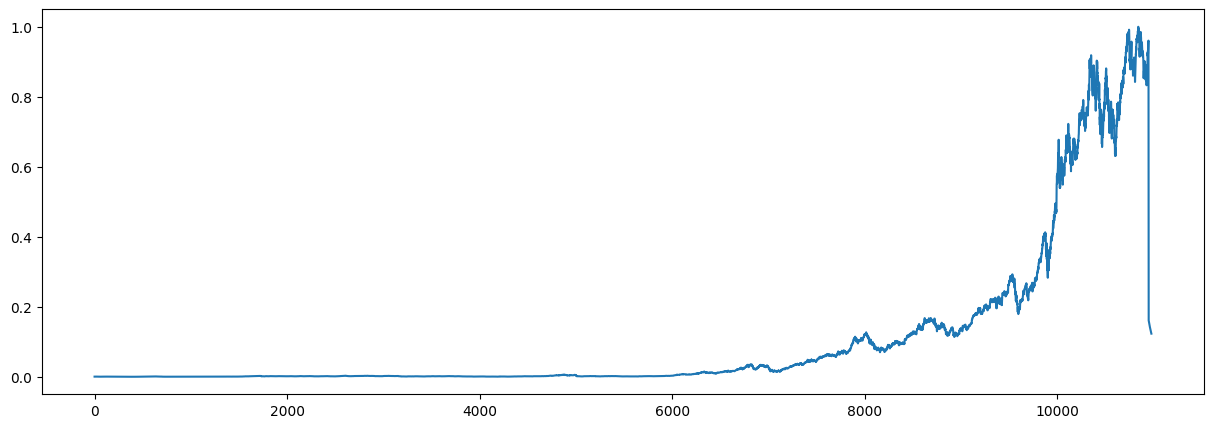

In [77]:
# Combine Output
df3=df1.tolist() # previous 
df3.extend(List_output) # New
plt.plot(df3)
# More training required
# Predict for 100 days
# we can use dropout layer and bidirectional Lstm